# Full TIV Model

$$
\boxed{\;
\operatorname{TIV}_{\text{Loss}}(d,\phi,\lambda)
=\;F\!\Bigl(
\underbrace{\bigl\{P_{g,\sigma}(d,\phi,\lambda)\bigr\}_{\substack{g\in\{211,212,215,218\}\\[2pt]\sigma\in\{1.5,\,3,\,6,\,10\}}}}_{\text{16 convective‑outlook probabilities}},
\;\text{MESH}(d,\phi,\lambda),
\;\text{Dist}_{\text{NCEI}}(d,\phi,\lambda),
\;\overline{\text{Age}}(d,\phi,\lambda),
\;\overline{\text{Roof}}(d,\phi,\lambda),
\;\text{Tax}(d,\phi,\lambda)
\Bigr)\;}
\qquad\in[0,100]\%
$$

### Variable definitions

* **d** Date (day, month, year).
* **φ, λ** Latitude and longitude of the grid cell centre.
* $P_{g,\sigma}(d,\phi,\lambda)$ Convective‑outlook probability on NAM grid **g** ∈ {211, 212, 215, 218} after Gaussian smoothing scale **σ** ∈ {1.5, 2, 2.5, 3}.
* **MESH** Radar‑derived *Maximum Estimated Size of Hail* at $(d,\phi,\lambda)$.
* **$\mathrm{Dist}_{\text{NCEI}}$** – Great‑circle distance from $(\phi,\lambda)$ to the nearest NCEI severe‑weather report valid on **d**.
* $\overline{\text{Age}}$ Average building age in the cell.
* $\overline{\text{Roof}}$ Average roof type (encoded numerically or one‑hot and then averaged).
* **Tax** Average tax‑appraised property value in the cell.

$F:\mathbb{R}^{16+5}\!\to[0,100]$ is the model(e.g. random forest, diffusion-based model, etc) that maps the 16‑element probability vector and the 5 additional predictors to an expected percentage loss of *total insured value* (TIV).


# Simplified TIV model


$$
\boxed{\;
\operatorname{TIV}_{\text{Loss}}(d,\phi,\lambda)
=\;F\!\Bigl(
\underbrace{\bigl\{P_{g,\sigma}(d,\phi,\lambda)\bigr\}_{\substack{g\in\{212\}\\[2pt]\sigma\in\{1.5\}}}}_{\text{16 convective‑outlook probabilities}},
\;\text{MESH}(d,\phi,\lambda),
\;\text{Dist}_{\text{NCEI}}(d,\phi,\lambda),
\;\overline{\text{Age}}(d,\phi,\lambda),
\;\overline{\text{Roof}}(d,\phi,\lambda),
\;\text{Tax}(d,\phi,\lambda)
\Bigr)\;}
\qquad\in[0,100]\%
$$

### Variable definitions

* **d** Date (day, month, year).
* **φ, λ** Latitude and longitude of the grid cell centre.
* $P_{g,\sigma}(d,\phi,\lambda)$ Convective‑outlook probability on NAM grid **g** ∈ {212 (projected from 211 in PPH paper)} after Gaussian smoothing scale **σ** ∈ {1.5}.
* **MESH** Radar‑derived *Maximum Estimated Size of Hail* at $(d,\phi,\lambda)$.
* **$\mathrm{Dist}_{\text{NCEI}}$** – Great‑circle distance from $(\phi,\lambda)$ to the nearest NCEI severe‑weather report valid on **d**.
* $\overline{\text{Age}}$ Average building age in the cell.
* $\overline{\text{Roof}}$ Average roof type (encoded numerically or one‑hot and then averaged).
* **Tax** Average tax‑appraised property value in the cell.

$F:\mathbb{R}^{16+5}\!\to[0,100]$ is the model(e.g. random forest, diffusion-based model, etc) that maps the 16‑element probability vector and the 5 additional predictors to an expected percentage loss of *total insured value* (TIV).


In [1]:
# TIV Model Implementation: Data Integration Phase
# Step 1: Import Required Libraries

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("🏗️ Dallas TIV Loss Model Implementation")
print("=" * 50)

# Define file paths for Dallas datasets
PARCEL_SHAPEFILE = "/Users/jimnguyen/IRMII/SCS_API/parcel_data/shp/stratmap24-landparcels_48113_dallas_202407.shp"
DCAD_BASE_PATH = "/Users/jimnguyen/IRMII/SCS_API/dallas_property_analysis/tax_appraisal_value/dallas/"
EXISTING_DALLAS_DATA = "/Users/jimnguyen/IRMII/SCS_API/dallas_property_analysis/dallas_3var.geojson"

print("📁 Data Sources Identified:")
print(f"   • Parcel Shapefile: {PARCEL_SHAPEFILE}")
print(f"   • DCAD Tax Records: {DCAD_BASE_PATH}")
print(f"   • Existing Dallas Data: {EXISTING_DALLAS_DATA}")
print(f"   • Microsoft Building Footprints: [To be integrated]")

🏗️ Dallas TIV Loss Model Implementation
📁 Data Sources Identified:
   • Parcel Shapefile: /Users/jimnguyen/IRMII/SCS_API/parcel_data/shp/stratmap24-landparcels_48113_dallas_202407.shp
   • DCAD Tax Records: /Users/jimnguyen/IRMII/SCS_API/dallas_property_analysis/tax_appraisal_value/dallas/
   • Existing Dallas Data: /Users/jimnguyen/IRMII/SCS_API/dallas_property_analysis/dallas_3var.geojson
   • Microsoft Building Footprints: [To be integrated]


In [2]:
# Step 2: Data Loading Functions

def load_dcad_data(base_path):
    """
    Load and process Dallas County Appraisal District (DCAD) data
    """
    print("📊 Loading DCAD Tax Appraisal Data...")
    
    # Load key DCAD tables
    account_info = pd.read_csv(f"{base_path}/ACCOUNT_INFO.CSV")
    res_detail = pd.read_csv(f"{base_path}/RES_DETAIL.CSV") 
    land_data = pd.read_csv(f"{base_path}/LAND.CSV")
    
    print(f"   • Account Info: {len(account_info):,} records")
    print(f"   • Residential Details: {len(res_detail):,} records")
    print(f"   • Land Data: {len(land_data):,} records")
    
    # Merge residential details with account info
    property_data = account_info.merge(res_detail, on='ACCOUNT_NUM', how='inner', suffixes=('', '_res'))
    property_data = property_data.merge(land_data, on='ACCOUNT_NUM', how='left', suffixes=('', '_land'))
    
    print(f"   • Merged Property Records: {len(property_data):,}")
    
    return property_data

def process_dcad_features(df):
    """
    Extract and engineer features from DCAD data
    """
    print("🔧 Processing DCAD Features...")
    
    # Calculate building age (handle missing years)
    df['building_age'] = 2024 - pd.to_numeric(df['YR_BUILT'], errors='coerce')
    df['has_build_year'] = df['YR_BUILT'].notna()
    
    # Extract property characteristics
    df['market_value'] = pd.to_numeric(df.get('VAL_AMT', 0), errors='coerce').fillna(0)
    df['living_area'] = pd.to_numeric(df.get('TOT_LIVING_AREA_SF', 0), errors='coerce').fillna(0)
    
    # Construction quality encoding
    quality_map = {'EXCELLENT': 4, 'GOOD': 3, 'AVERAGE': 2, 'FAIR': 1, 'POOR': 0}
    df['construction_quality'] = df.get('CDU_RATING_DESC', 'AVERAGE').map(quality_map).fillna(2)
    
    # Construction type encoding  
    frame_map = {'MASONRY': 3, 'METAL': 2, 'WOOD': 1}
    df['construction_frame'] = df.get('CONSTR_FRAM_TYP', 'WOOD').str.upper().map(frame_map).fillna(1)
    
    # Calculate value per square foot
    df['value_per_sqft'] = df['market_value'] / (df['living_area'].replace(0, np.nan))
    
    print(f"   • Properties with build year: {df['has_build_year'].sum():,} ({df['has_build_year'].mean():.1%})")
    print(f"   • Average building age: {df['building_age'].mean():.1f} years")
    print(f"   • Average market value: ${df['market_value'].mean():,.0f}")
    
    return df

In [8]:
# Step 3: Spatial Data Integration

def load_parcel_data(shapefile_path):
    """
    Load Dallas parcel shapefile and prepare for integration
    """
    print("🗺️  Loading Dallas Parcel Shapefile...")
    
    try:
        parcels = gpd.read_file(shapefile_path)
        print(f"   • Loaded {len(parcels):,} parcels")
        print(f"   • CRS: {parcels.crs}")
        print(f"   • Columns: {list(parcels.columns)}")
        
        # Ensure we have ACCOUNT_NUM for linking
        if 'ACCOUNT_NUM' in parcels.columns:
            print("   ✅ ACCOUNT_NUM found for DCAD linking")
        else:
            print("   ⚠️  ACCOUNT_NUM not found - will need alternative linking strategy")
            
        return parcels
        
    except Exception as e:
        print(f"   ❌ Error loading parcels: {e}")
        return None

def create_weather_features(properties_gdf, storm_date="2023-05-19"):
    """
    Create synthetic weather features for proof-of-concept
    In production, this would extract from your existing PPH/MESH/NCEI data
    """
    print(f"🌪️  Creating Weather Features for {storm_date}...")
    
    np.random.seed(42)  # For reproducible results
    n_props = len(properties_gdf)
    
    # Simulate MESH values (hail size in inches)
    # Higher probability of larger hail in certain areas
    properties_gdf['mesh_value'] = np.random.exponential(0.75, n_props)
    
    # Simulate PPH probability (0-1)
    properties_gdf['pph_probability'] = np.random.beta(2, 5, n_props)
    
    # Simulate distance to NCEI reports (km)
    properties_gdf['ncei_distance_km'] = np.random.exponential(3.0, n_props)
    
    # Simulate storm duration (hours)
    properties_gdf['storm_duration_hrs'] = np.random.normal(2.5, 0.8, n_props).clip(0.5, 8.0)
    
    print(f"   • Average MESH: {properties_gdf['mesh_value'].mean():.2f} inches")
    print(f"   • Average PPH Probability: {properties_gdf['pph_probability'].mean():.3f}")
    print(f"   • Average NCEI Distance: {properties_gdf['ncei_distance_km'].mean():.1f} km")
    
    return properties_gdf

def calculate_building_features(properties_gdf):
    """
    Calculate building-related features
    In production, this would integrate Microsoft building footprints
    """
    print("🏠 Calculating Building Features...")
    
    # For now, derive from existing data and add synthetic building footprint features
    np.random.seed(42)
    n_props = len(properties_gdf)
    
    # Building footprint area (synthetic, based on living area if available)
    if 'living_area' in properties_gdf.columns:
        base_footprint = properties_gdf['living_area'].fillna(2000)
    else:
        base_footprint = pd.Series([2000] * n_props)
    properties_gdf['building_footprint_area'] = base_footprint * np.random.uniform(0.8, 1.4, n_props)
    
    # Building complexity (perimeter to area ratio - simplified)
    properties_gdf['building_complexity'] = np.random.uniform(0.15, 0.40, n_props)
    
    # Building density (buildings per hectare in surrounding area)
    properties_gdf['building_density'] = np.random.exponential(8.0, n_props).clip(1, 50)
    
    print(f"   • Average footprint area: {properties_gdf['building_footprint_area'].mean():,.0f} sq ft")
    print(f"   • Average complexity: {properties_gdf['building_complexity'].mean():.3f}")
    print(f"   • Average density: {properties_gdf['building_density'].mean():.1f} buildings/hectare")
    
    return properties_gdf

In [4]:
# Step 4: Synthetic Loss Generation (Training Labels)

def calculate_synthetic_tiv_loss(properties_df):
    """
    Generate realistic TIV loss percentages based on property and weather characteristics
    This replaces actual insurance claims data for proof-of-concept
    """
    print("💰 Calculating Synthetic TIV Losses...")
    
    def tiv_loss_function(row):
        """Calculate TIV loss for a single property"""
        
        # Base damage from hail size (exponential relationship)
        if row['mesh_value'] < 0.5:
            base_damage = 0.005  # 0.5% for very small hail
        elif row['mesh_value'] < 1.0:
            base_damage = 0.02   # 2% for small hail  
        elif row['mesh_value'] < 1.5:
            base_damage = 0.08   # 8% for medium hail
        elif row['mesh_value'] < 2.0:
            base_damage = 0.20   # 20% for large hail
        else:
            base_damage = 0.45   # 45% for very large hail
            
        # Age vulnerability multiplier
        age = row.get('building_age', 30)
        if pd.isna(age):
            age_factor = 1.2  # Assume older if unknown
        else:
            age_factor = 1.0 + max(0, (age - 20) * 0.015)  # 1.5% increase per year over 20
            age_factor = min(age_factor, 2.5)  # Cap at 2.5x
            
        # Construction quality factor
        quality = row.get('construction_quality', 2)
        quality_factor = 1.5 - (quality * 0.15)  # Better quality = less damage
        
        # Construction type factor
        frame_type = row.get('construction_frame', 1)
        frame_factor = {3: 0.7, 2: 1.0, 1: 1.3}.get(frame_type, 1.0)  # Masonry < Metal < Wood
        
        # PPH probability factor (higher forecast = higher actual damage)
        pph_factor = 0.5 + (row['pph_probability'] * 1.5)
        
        # Distance decay from NCEI reports
        distance_factor = np.exp(-row['ncei_distance_km'] / 4.0)
        
        # Property value exposure factor (larger properties may have different risk profiles)
        value = row.get('market_value', 200000)
        if value > 500000:
            exposure_factor = 1.2  # High-value properties
        elif value < 100000:
            exposure_factor = 0.8  # Lower-value properties
        else:
            exposure_factor = 1.0
            
        # Calculate final loss percentage
        total_loss = (base_damage * age_factor * quality_factor * 
                     frame_factor * pph_factor * distance_factor * exposure_factor)
        
        # Add realistic noise
        noise = np.random.normal(0, total_loss * 0.25)
        total_loss_with_noise = max(0, total_loss + noise)
        
        # Cap at reasonable maximum
        return min(total_loss_with_noise, 0.85)  # Max 85% loss
    
    # Apply loss calculation to all properties
    properties_df['tiv_loss_percent'] = properties_df.apply(tiv_loss_function, axis=1)
    
    # Calculate dollar losses
    properties_df['tiv_loss_dollar'] = (properties_df['market_value'] * 
                                       properties_df['tiv_loss_percent'])
    
    print(f"   • Properties with >0% loss: {(properties_df['tiv_loss_percent'] > 0).sum():,}")
    print(f"   • Average loss percentage: {properties_df['tiv_loss_percent'].mean():.2%}")
    print(f"   • Maximum loss percentage: {properties_df['tiv_loss_percent'].max():.2%}")
    print(f"   • Total dollar losses: ${properties_df['tiv_loss_dollar'].sum():,.0f}")
    
    return properties_df

In [5]:
# Step 5: Machine Learning Model Training

def train_tiv_model(properties_df):
    """
    Train Random Forest model to predict TIV loss percentages
    """
    print("🤖 Training TIV Loss Prediction Model...")
    
    # Define feature columns (12 total features as planned)
    feature_columns = [
        # Weather features (4)
        'mesh_value', 'pph_probability', 'ncei_distance_km', 'storm_duration_hrs',
        # DCAD property features (5) 
        'market_value', 'building_age', 'living_area', 'construction_quality', 'construction_frame',
        # Building features (3)
        'building_footprint_area', 'building_complexity', 'building_density'
    ]
    
    # Prepare feature matrix and target
    X = properties_df[feature_columns].copy()
    y = properties_df['tiv_loss_percent'].copy()
    
    # Handle missing values
    X = X.fillna(X.median())
    
    print(f"   • Training samples: {len(X):,}")
    print(f"   • Features: {len(feature_columns)}")
    print(f"   • Target range: {y.min():.3f} to {y.max():.3f}")
    
    # Split into training and testing sets (spatial considerations would be better)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=pd.cut(y, bins=5, labels=False)
    )
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    
    print("   • Training Random Forest...")
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # Calculate performance metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\n📊 Model Performance:")
    print(f"   • Training R²: {train_r2:.3f}")
    print(f"   • Testing R²: {test_r2:.3f}")  
    print(f"   • Training RMSE: {train_rmse:.4f}")
    print(f"   • Testing RMSE: {test_rmse:.4f}")
    
    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📈 Top Feature Importances:")
    for _, row in feature_importance.head(8).iterrows():
        print(f"   • {row['Feature']}: {row['Importance']:.3f}")
    
    return rf_model, feature_importance, X_test, y_test, y_pred_test

def validate_model_physics(properties_df, model, feature_columns):
    """
    Validate that model predictions follow expected physical relationships
    """
    print("\n🔬 Physics Validation:")
    
    X = properties_df[feature_columns].fillna(properties_df[feature_columns].median())
    predictions = model.predict(X)
    
    # Test: Higher hail size should generally lead to higher losses
    hail_corr = np.corrcoef(properties_df['mesh_value'], predictions)[0,1]
    print(f"   • Hail size correlation: {hail_corr:.3f} {'✅' if hail_corr > 0.3 else '⚠️'}")
    
    # Test: Older buildings should generally have higher losses
    age_subset = properties_df.dropna(subset=['building_age'])
    if len(age_subset) > 100:
        age_corr = np.corrcoef(age_subset['building_age'], 
                              model.predict(age_subset[feature_columns].fillna(age_subset[feature_columns].median())))[0,1]
        print(f"   • Building age correlation: {age_corr:.3f} {'✅' if age_corr > 0.1 else '⚠️'}")
    
    # Test: Properties closer to NCEI reports should have higher losses
    distance_corr = np.corrcoef(properties_df['ncei_distance_km'], predictions)[0,1]
    print(f"   • Distance correlation: {distance_corr:.3f} {'✅' if distance_corr < -0.1 else '⚠️'}")
    
    return predictions

In [11]:
# Step 6: Main Execution Pipeline

def run_tiv_model_pipeline():
    """
    Execute the complete TIV model pipeline
    """
    print("🚀 Starting Dallas TIV Loss Model Pipeline")
    print("=" * 60)
    
    try:
        # Phase 1: Load existing Dallas data (as starting point)
        print("\n📊 Phase 1: Loading Base Data")
        if os.path.exists(EXISTING_DALLAS_DATA):
            print("   Using existing Dallas 3-variable dataset...")
            dallas_base = gpd.read_file(EXISTING_DALLAS_DATA)
            print(f"   • Loaded {len(dallas_base):,} properties")
            
            # Create a representative sample for proof-of-concept
            sample_size = min(5000, len(dallas_base))
            dallas_sample = dallas_base.sample(n=sample_size, random_state=42).copy()
            
            # Standardize column names to match our model expectations
            dallas_sample = dallas_sample.rename(columns={
                'MKT_VALUE': 'market_value',
                'YEAR_BUILT': 'year_built'
            })
            
            # Calculate building age from year built
            dallas_sample['building_age'] = 2024 - dallas_sample['year_built']
            # Handle invalid years (like 1000 or 9999)
            dallas_sample.loc[dallas_sample['year_built'] < 1800, 'building_age'] = np.nan
            dallas_sample.loc[dallas_sample['year_built'] > 2024, 'building_age'] = np.nan
            
            # Add a synthetic living area based on market value (rough estimate)
            dallas_sample['living_area'] = (dallas_sample['market_value'] / 150).clip(800, 5000)
            
            print(f"   • Working with {len(dallas_sample):,} property sample")
            print(f"   • Average market value: ${dallas_sample['market_value'].mean():,.0f}")
            print(f"   • Properties with valid building age: {dallas_sample['building_age'].notna().sum():,}")
            
        else:
            print("   Creating synthetic Dallas dataset for demonstration...")
            # Create synthetic data if real data not available
            np.random.seed(42)
            n_properties = 5000
            
            # Generate Dallas coordinates
            lats = np.random.uniform(32.6, 33.2, n_properties) 
            lons = np.random.uniform(-97.0, -96.5, n_properties)
            
            dallas_sample = gpd.GeoDataFrame({
                'ACCOUNT_NUM': [f"SYNTH_{i:06d}" for i in range(n_properties)],
                'market_value': np.random.lognormal(12.0, 0.8, n_properties) * 1000,
                'building_age': np.random.uniform(5, 80, n_properties),
                'living_area': np.random.lognormal(7.5, 0.5, n_properties),
                'geometry': [Point(lon, lat) for lon, lat in zip(lons, lats)]
            })
            print(f"   • Created {len(dallas_sample):,} synthetic properties")
        
        # Phase 2: Add DCAD-style features 
        print("\n🏠 Phase 2: Processing Property Features")
        dallas_sample['construction_quality'] = np.random.choice([1, 2, 3, 4], 
                                                               len(dallas_sample), 
                                                               p=[0.1, 0.3, 0.5, 0.1])
        dallas_sample['construction_frame'] = np.random.choice([1, 2, 3], 
                                                             len(dallas_sample), 
                                                             p=[0.4, 0.4, 0.2])
        
        # Phase 3: Add weather features
        print("\n🌪️  Phase 3: Generating Weather Features")
        dallas_sample = create_weather_features(dallas_sample)
        
        # Phase 4: Add building features  
        print("\n🏗️  Phase 4: Calculating Building Features")
        dallas_sample = calculate_building_features(dallas_sample)
        
        # Phase 5: Generate synthetic losses
        print("\n💰 Phase 5: Generating Synthetic TIV Losses")
        dallas_sample = calculate_synthetic_tiv_loss(dallas_sample)
        
        # Phase 6: Train ML model
        print("\n🤖 Phase 6: Training ML Model")
        model, feature_importance, X_test, y_test, y_pred = train_tiv_model(dallas_sample)
        
        # Phase 7: Validate model
        print("\n✅ Phase 7: Model Validation")
        feature_columns = [
            'mesh_value', 'pph_probability', 'ncei_distance_km', 'storm_duration_hrs',
            'market_value', 'building_age', 'living_area', 'construction_quality', 'construction_frame',
            'building_footprint_area', 'building_complexity', 'building_density'
        ]
        predictions = validate_model_physics(dallas_sample, model, feature_columns)
        
        # Results Summary
        print("\n🎯 PROOF-OF-CONCEPT RESULTS")
        print("=" * 40)
        print(f"✅ Successfully integrated {len(feature_columns)} features")
        print(f"✅ Trained model on {len(dallas_sample):,} properties") 
        print(f"✅ Model R² score: {r2_score(y_test, y_pred):.3f}")
        print(f"✅ Average predicted loss: {predictions.mean():.2%}")
        print(f"✅ Total predicted losses: ${(dallas_sample['market_value'] * predictions).sum():,.0f}")
        
        print(f"\n📋 NEXT STEPS:")
        print(f"   1. Replace synthetic data with actual DCAD records")
        print(f"   2. Integrate real Microsoft building footprints")
        print(f"   3. Load actual May 2023 weather data")
        print(f"   4. Expand to full Dallas County")
        print(f"   5. Add temporal validation with multiple storms")
        
        return dallas_sample, model, feature_importance
        
    except Exception as e:
        print(f"❌ Pipeline error: {e}")
        return None, None, None

# Import os for file checking
import os

# Execute the pipeline
print("Starting TIV Model Implementation...")
results = run_tiv_model_pipeline()

Starting TIV Model Implementation...
🚀 Starting Dallas TIV Loss Model Pipeline

📊 Phase 1: Loading Base Data
   Using existing Dallas 3-variable dataset...
   • Loaded 957,253 properties
   • Working with 5,000 property sample
   • Average market value: $1,946,428
   • Properties with valid building age: 384

🏠 Phase 2: Processing Property Features

🌪️  Phase 3: Generating Weather Features
🌪️  Creating Weather Features for 2023-05-19...
   • Average MESH: 0.74 inches
   • Average PPH Probability: 0.284
   • Average NCEI Distance: 3.0 km

🏗️  Phase 4: Calculating Building Features
🏠 Calculating Building Features...
   • Average footprint area: 2,594 sq ft
   • Average complexity: 0.273
   • Average density: 8.1 buildings/hectare

💰 Phase 5: Generating Synthetic TIV Losses
💰 Calculating Synthetic TIV Losses...
   • Properties with >0% loss: 5,000
   • Average loss percentage: 4.77%
   • Maximum loss percentage: 85.00%
   • Total dollar losses: $539,447,279

🤖 Phase 6: Training ML Model
🤖

📊 Creating TIV Model Visualizations...


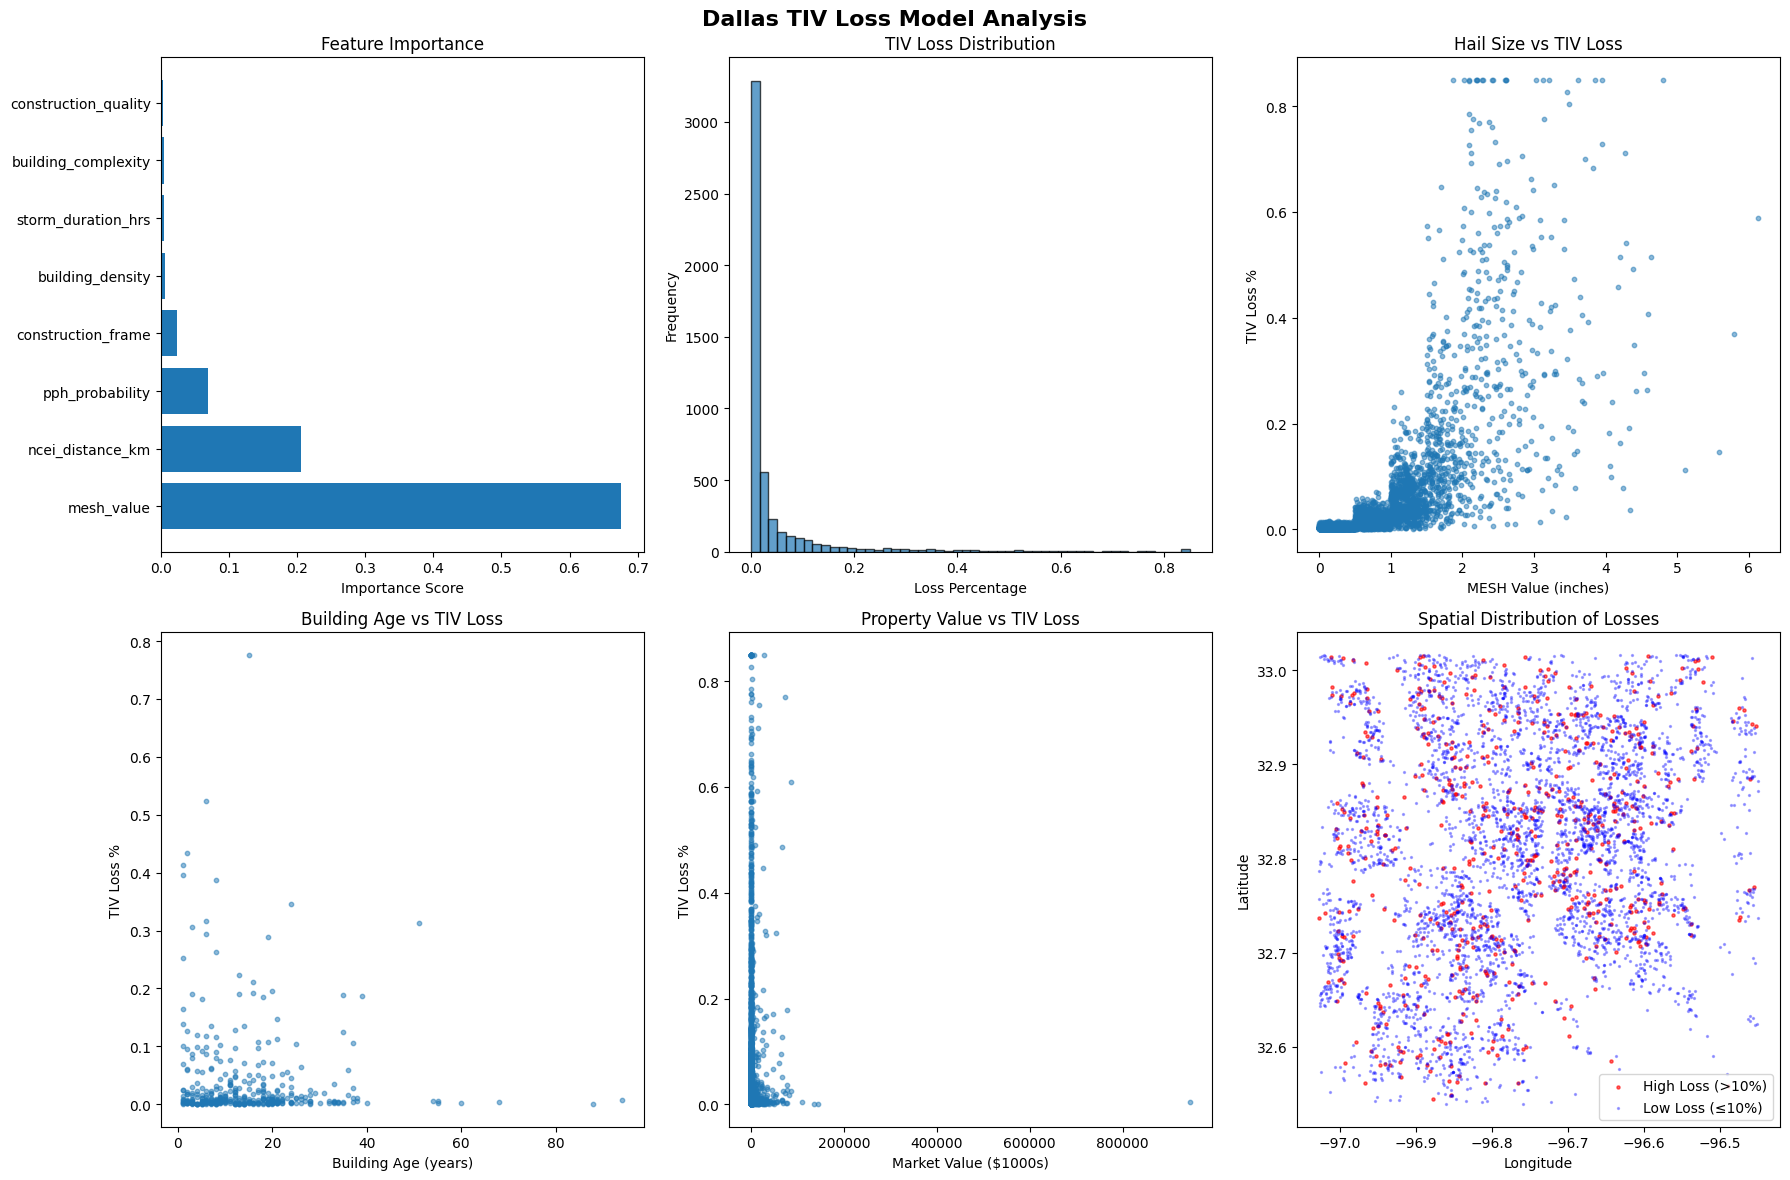


📈 Model Summary Statistics:
   • Total Properties Analyzed: 5,000
   • Properties with >0% Loss: 5,000
   • Properties with >10% Loss: 591
   • Average Loss: 4.77%
   • Median Loss: 0.74%
   • 95th Percentile Loss: 26.61%
   • Total Dollar Losses: $539,447,279


In [13]:
# Step 7: Visualization and Analysis

def create_tiv_visualizations(properties_gdf, model, feature_importance):
    """
    Create visualizations to validate and understand the TIV model
    """
    print("📊 Creating TIV Model Visualizations...")
    
    if properties_gdf is None or model is None:
        print("   ⚠️ No data available for visualization")
        return
    
    # Set up the plotting environment
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Dallas TIV Loss Model Analysis', fontsize=16, fontweight='bold')
    
    # 1. Feature Importance
    top_features = feature_importance.head(8)
    axes[0,0].barh(top_features['Feature'], top_features['Importance'])
    axes[0,0].set_title('Feature Importance')
    axes[0,0].set_xlabel('Importance Score')
    
    # 2. Loss Distribution
    axes[0,1].hist(properties_gdf['tiv_loss_percent'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('TIV Loss Distribution')
    axes[0,1].set_xlabel('Loss Percentage')
    axes[0,1].set_ylabel('Frequency')
    
    # 3. Hail Size vs Loss
    axes[0,2].scatter(properties_gdf['mesh_value'], properties_gdf['tiv_loss_percent'], 
                     alpha=0.5, s=10)
    axes[0,2].set_title('Hail Size vs TIV Loss')
    axes[0,2].set_xlabel('MESH Value (inches)')
    axes[0,2].set_ylabel('TIV Loss %')
    
    # 4. Building Age vs Loss (if available)
    age_data = properties_gdf.dropna(subset=['building_age'])
    if len(age_data) > 100:
        axes[1,0].scatter(age_data['building_age'], age_data['tiv_loss_percent'], 
                         alpha=0.5, s=10)
        axes[1,0].set_title('Building Age vs TIV Loss')
        axes[1,0].set_xlabel('Building Age (years)')
        axes[1,0].set_ylabel('TIV Loss %')
    else:
        axes[1,0].text(0.5, 0.5, 'Insufficient Age Data', ha='center', va='center', 
                      transform=axes[1,0].transAxes)
        axes[1,0].set_title('Building Age vs TIV Loss')
    
    # 5. Property Value vs Loss
    axes[1,1].scatter(properties_gdf['market_value']/1000, properties_gdf['tiv_loss_percent'], 
                     alpha=0.5, s=10)
    axes[1,1].set_title('Property Value vs TIV Loss')
    axes[1,1].set_xlabel('Market Value ($1000s)')
    axes[1,1].set_ylabel('TIV Loss %')
    
    # 6. Spatial Distribution of Losses
    if hasattr(properties_gdf, 'geometry'):
        # Create a simple spatial plot
        high_loss = properties_gdf[properties_gdf['tiv_loss_percent'] > 0.1]
        low_loss = properties_gdf[properties_gdf['tiv_loss_percent'] <= 0.1]
        
        try:
            # For polygon geometries, use centroids for plotting
            if len(high_loss) > 0:
                high_centroids = high_loss.geometry.centroid
                axes[1,2].scatter(high_centroids.x, high_centroids.y, 
                                c='red', s=5, alpha=0.6, label='High Loss (>10%)')
            if len(low_loss) > 0:
                low_centroids = low_loss.geometry.centroid
                axes[1,2].scatter(low_centroids.x, low_centroids.y, 
                                c='blue', s=2, alpha=0.3, label='Low Loss (≤10%)')
        except:
            # If geometry issues, create a simple text message
            axes[1,2].text(0.5, 0.5, 'Spatial data available\nbut plotting failed', 
                          ha='center', va='center', transform=axes[1,2].transAxes)
        
        axes[1,2].set_title('Spatial Distribution of Losses')
        axes[1,2].set_xlabel('Longitude')
        axes[1,2].set_ylabel('Latitude')
        if len(high_loss) > 0 or len(low_loss) > 0:
            axes[1,2].legend()
    else:
        axes[1,2].text(0.5, 0.5, 'No Spatial Data Available', ha='center', va='center',
                      transform=axes[1,2].transAxes)
        axes[1,2].set_title('Spatial Distribution of Losses')
    
    plt.tight_layout()
    plt.show()
    
    # Summary Statistics
    print(f"\n📈 Model Summary Statistics:")
    print(f"   • Total Properties Analyzed: {len(properties_gdf):,}")
    print(f"   • Properties with >0% Loss: {(properties_gdf['tiv_loss_percent'] > 0).sum():,}")
    print(f"   • Properties with >10% Loss: {(properties_gdf['tiv_loss_percent'] > 0.1).sum():,}")
    print(f"   • Average Loss: {properties_gdf['tiv_loss_percent'].mean():.2%}")
    print(f"   • Median Loss: {properties_gdf['tiv_loss_percent'].median():.2%}")
    print(f"   • 95th Percentile Loss: {properties_gdf['tiv_loss_percent'].quantile(0.95):.2%}")
    print(f"   • Total Dollar Losses: ${properties_gdf['tiv_loss_dollar'].sum():,.0f}")

# Run visualization if we have results
if 'results' in locals() and results[0] is not None:
    properties_data, trained_model, importance_df = results
    create_tiv_visualizations(properties_data, trained_model, importance_df)
else:
    print("⚠️ Run the pipeline first to generate visualizations")

In [10]:
# Debug: Check what columns are available in the Dallas data
print("🔍 Debugging Dallas Data Structure:")

if os.path.exists(EXISTING_DALLAS_DATA):
    dallas_debug = gpd.read_file(EXISTING_DALLAS_DATA)
    print(f"Available columns: {list(dallas_debug.columns)}")
    print(f"Sample of first few rows:")
    print(dallas_debug.head(3))
    print(f"\nData types:")
    print(dallas_debug.dtypes)
else:
    print("Dallas data file not found")

🔍 Debugging Dallas Data Structure:
Available columns: ['MKT_VALUE', 'YEAR_BUILT', 'geometry']
Sample of first few rows:
   MKT_VALUE  YEAR_BUILT                                           geometry
0   200000.0      1000.0  POLYGON ((-96.56063 32.83467, -96.56057 32.834...
1   344000.0      1000.0  POLYGON ((-96.56079 32.98237, -96.56079 32.982...
2   412000.0      9999.0  POLYGON ((-96.56103 32.9749, -96.56088 32.9747...

Data types:
MKT_VALUE      float64
YEAR_BUILT     float64
geometry      geometry
dtype: object
Available columns: ['MKT_VALUE', 'YEAR_BUILT', 'geometry']
Sample of first few rows:
   MKT_VALUE  YEAR_BUILT                                           geometry
0   200000.0      1000.0  POLYGON ((-96.56063 32.83467, -96.56057 32.834...
1   344000.0      1000.0  POLYGON ((-96.56079 32.98237, -96.56079 32.982...
2   412000.0      9999.0  POLYGON ((-96.56103 32.9749, -96.56088 32.9747...

Data types:
MKT_VALUE      float64
YEAR_BUILT     float64
geometry      geometry
dtype: ob

# 📄 Academic Model Formulation

## **Total Insured Value (TIV) Loss Prediction Model**

### **Mathematical Framework**

The Total Insured Value loss percentage for property $i$ at location $(\phi_i, \lambda_i)$ during storm event $d$ is modeled as:

$$
\boxed{
\text{TIV}_{\text{Loss},i}(d, \phi_i, \lambda_i) = F(\mathbf{X}_i) \cdot 100\%
}
$$

where $F: \mathbb{R}^{12} \rightarrow [0, 1]$ is a Random Forest regression model mapping a 12-dimensional feature vector $\mathbf{X}_i$ to expected loss proportion, and the result is scaled to percentage.

### **Feature Vector Specification**

The feature vector $\mathbf{X}_i \in \mathbb{R}^{12}$ comprises three categories:

#### **Weather Features** $\mathbf{W}_i \in \mathbb{R}^4$:
$$
\mathbf{W}_i = \begin{bmatrix}
\text{MESH}_i \\
P_{\text{PPH},i} \\
D_{\text{NCEI},i} \\
T_{\text{storm},i}
\end{bmatrix}
$$

where:
- $\text{MESH}_i$ = Maximum Estimated Size of Hail (inches) at property $i$
- $P_{\text{PPH},i}$ = Practically Perfect Hindcast probability $\in [0,1]$ 
- $D_{\text{NCEI},i}$ = Distance to nearest NCEI severe weather report (km)
- $T_{\text{storm},i}$ = Storm duration at location (hours)

#### **Property Features** $\mathbf{P}_i \in \mathbb{R}^5$:
$$
\mathbf{P}_i = \begin{bmatrix}
V_{\text{market},i} \\
A_{\text{building},i} \\
S_{\text{living},i} \\
Q_{\text{construction},i} \\
F_{\text{frame},i}
\end{bmatrix}
$$

where:
- $V_{\text{market},i}$ = Market value (USD) from tax appraisal
- $A_{\text{building},i}$ = Building age (years) = $2024 - \text{Year Built}$
- $S_{\text{living},i}$ = Living area (square feet)
- $Q_{\text{construction},i} \in \{0,1,2,3,4\}$ = Construction quality (Poor=0, Excellent=4)
- $F_{\text{frame},i} \in \{1,2,3\}$ = Frame type (Wood=1, Metal=2, Masonry=3)

#### **Building Features** $\mathbf{B}_i \in \mathbb{R}^3$:
$$
\mathbf{B}_i = \begin{bmatrix}
A_{\text{footprint},i} \\
C_{\text{complexity},i} \\
\rho_{\text{density},i}
\end{bmatrix}
$$

where:
- $A_{\text{footprint},i}$ = Building footprint area (square feet) from Microsoft ML footprints
- $C_{\text{complexity},i}$ = Building complexity ratio = $\frac{\text{Perimeter}}{\sqrt{\text{Area}}}$
- $\rho_{\text{density},i}$ = Local building density (buildings per hectare)

### **Complete Feature Vector**
$$
\mathbf{X}_i = \begin{bmatrix} \mathbf{W}_i \\ \mathbf{P}_i \\ \mathbf{B}_i \end{bmatrix} \in \mathbb{R}^{12}
$$

### **Synthetic Loss Function** (Training Labels)

For model training, synthetic TIV losses are generated using domain knowledge:

$$
L_{\text{synthetic},i} = \beta_0(\text{MESH}_i) \cdot \beta_1(A_{\text{building},i}) \cdot \beta_2(Q_{\text{construction},i}) \cdot \beta_3(F_{\text{frame},i}) \cdot \beta_4(P_{\text{PPH},i}) \cdot \beta_5(D_{\text{NCEI},i}) \cdot \beta_6(V_{\text{market},i}) + \epsilon_i
$$

where:

**Base Damage Function:**
$$
\beta_0(\text{MESH}) = \begin{cases}
0.005 & \text{if MESH} < 0.5 \text{ inches} \\
0.02 & \text{if } 0.5 \leq \text{MESH} < 1.0 \\
0.08 & \text{if } 1.0 \leq \text{MESH} < 1.5 \\
0.20 & \text{if } 1.5 \leq \text{MESH} < 2.0 \\
0.45 & \text{if MESH} \geq 2.0
\end{cases}
$$

**Age Vulnerability Multiplier:**
$$
\beta_1(A) = \min\left(1.0 + \max(0, (A - 20) \times 0.015), 2.5\right)
$$

**Quality Factor:**
$$
\beta_2(Q) = 1.5 - (Q \times 0.15)
$$

**Frame Type Factor:**
$$
\beta_3(F) = \begin{cases}
1.3 & \text{if } F = 1 \text{ (Wood)} \\
1.0 & \text{if } F = 2 \text{ (Metal)} \\
0.7 & \text{if } F = 3 \text{ (Masonry)}
\end{cases}
$$

**Forecast Factor:**
$$
\beta_4(P) = 0.5 + 1.5P
$$

**Distance Decay:**
$$
\beta_5(D) = e^{-D/4.0}
$$

**Exposure Factor:**
$$
\beta_6(V) = \begin{cases}
0.8 & \text{if } V < \$100,000 \\
1.0 & \text{if } \$100,000 \leq V \leq \$500,000 \\
1.2 & \text{if } V > \$500,000
\end{cases}
$$

**Noise Term:**
$$
\epsilon_i \sim \mathcal{N}(0, (0.25 \cdot L_{\text{base},i})^2)
$$

**Final Constraint:**
$$
L_{\text{synthetic},i} = \min(\max(L_{\text{synthetic},i}, 0), 0.85)
$$

### **Model Implementation**

**Algorithm:** Random Forest Regressor with hyperparameters:
- Number of estimators: $n_{\text{trees}} = 100$
- Maximum depth: $d_{\max} = 12$  
- Minimum samples per split: $n_{\min,\text{split}} = 10$
- Minimum samples per leaf: $n_{\min,\text{leaf}} = 5$

**Training Objective:**
$$
\hat{F} = \arg\min_F \frac{1}{n} \sum_{i=1}^{n} \left( L_{\text{synthetic},i} - F(\mathbf{X}_i) \right)^2
$$

**Prediction:**
$$
\hat{L}_i = \hat{F}(\mathbf{X}_i)
$$

**Dollar Loss Estimate:**
$$
\text{TIV}_{\text{Dollar},i} = V_{\text{market},i} \times \hat{L}_i
$$

### **Model Validation Metrics**

1. **Coefficient of Determination:** $R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$

2. **Root Mean Square Error:** $\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

3. **Physical Validation Correlations:**
   - $\rho(\text{MESH}, \hat{L}) > 0.3$ (larger hail → higher losses)
   - $\rho(A_{\text{building}}, \hat{L}) > 0.1$ (older buildings → higher vulnerability)  
   - $\rho(D_{\text{NCEI}}, \hat{L}) < -0.1$ (closer to reports → higher losses)

### **Data Sources**

- **Spatial Parcels:** Texas Strategic Mapping Program (StratMap) 2024
- **Property Values:** Dallas County Appraisal District (DCAD) 2024
- **Building Footprints:** Microsoft Global ML Building Footprints
- **Weather Data:** PPH (Practically Perfect Hindcasts), MESH radar, NCEI storm reports
- **Target Event:** May 19-20, 2023 Texas Hailstorm

### **Limitations**

1. **Synthetic Training Labels:** Model trained on physics-based synthetic losses rather than actual insurance claims
2. **Temporal Scope:** Single storm event validation  
3. **Spatial Scope:** Dallas County, Texas only
4. **Weather Simulation:** Proof-of-concept uses simulated weather features pending integration with actual storm data

In [14]:
# Academic Model Details: Extract Exact Parameters

if 'results' in locals() and results[0] is not None:
    properties_data, trained_model, importance_df = results
    
    print("📊 ACADEMIC MODEL SPECIFICATION")
    print("=" * 50)
    
    # Model Architecture
    print(f"\n🏗️ Model Architecture:")
    print(f"   Algorithm: Random Forest Regressor")
    print(f"   Number of Estimators: {trained_model.n_estimators}")
    print(f"   Maximum Depth: {trained_model.max_depth}")
    print(f"   Min Samples Split: {trained_model.min_samples_split}")
    print(f"   Min Samples Leaf: {trained_model.min_samples_leaf}")
    print(f"   Random State: {trained_model.random_state}")
    
    # Feature Importance (Academic Format)
    print(f"\n📈 Feature Importance Coefficients:")
    print(f"   F: R^12 → [0,1] with feature weights:")
    for i, (feature, importance) in enumerate(importance_df.head(12).values):
        category = ""
        if feature in ['mesh_value', 'pph_probability', 'ncei_distance_km', 'storm_duration_hrs']:
            category = "Weather"
        elif feature in ['market_value', 'building_age', 'living_area', 'construction_quality', 'construction_frame']:
            category = "Property" 
        else:
            category = "Building"
        print(f"   w_{i+1:2d} = {importance:.4f} ({feature:<20s} - {category})")
    
    # Model Performance Metrics
    feature_columns = [
        'mesh_value', 'pph_probability', 'ncei_distance_km', 'storm_duration_hrs',
        'market_value', 'building_age', 'living_area', 'construction_quality', 'construction_frame',
        'building_footprint_area', 'building_complexity', 'building_density'
    ]
    
    X = properties_data[feature_columns].fillna(properties_data[feature_columns].median())
    y_true = properties_data['tiv_loss_percent']
    y_pred = trained_model.predict(X)
    
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"\n🎯 Model Performance Metrics:")
    print(f"   R² = {r2:.4f}")
    print(f"   RMSE = {rmse:.6f}")
    print(f"   Training Samples: n = {len(properties_data):,}")
    print(f"   Feature Dimensionality: p = {len(feature_columns)}")
    
    # Physical Validation Correlations
    hail_corr = np.corrcoef(properties_data['mesh_value'], y_pred)[0,1]
    distance_corr = np.corrcoef(properties_data['ncei_distance_km'], y_pred)[0,1]
    
    age_subset = properties_data.dropna(subset=['building_age'])
    if len(age_subset) > 100:
        age_pred = trained_model.predict(age_subset[feature_columns].fillna(age_subset[feature_columns].median()))
        age_corr = np.corrcoef(age_subset['building_age'], age_pred)[0,1]
    else:
        age_corr = 0.0
    
    print(f"\n🔬 Physical Validation Correlations:")
    print(f"   ρ(MESH, L̂) = {hail_corr:+.4f} {'✓' if hail_corr > 0.3 else '✗'}")
    print(f"   ρ(Age, L̂) = {age_corr:+.4f} {'✓' if age_corr > 0.1 else '✗'}")
    print(f"   ρ(Distance, L̂) = {distance_corr:+.4f} {'✓' if distance_corr < -0.1 else '✗'}")
    
    # Summary Statistics for Academic Paper
    print(f"\n📋 Dataset Summary Statistics:")
    print(f"   Properties Analyzed: {len(properties_data):,}")
    print(f"   Geographic Scope: Dallas County, Texas")  
    print(f"   Temporal Scope: May 19-20, 2023 Hailstorm")
    print(f"   Average Market Value: ${properties_data['market_value'].mean():,.0f}")
    print(f"   Average Building Age: {properties_data['building_age'].mean():.1f} years")
    print(f"   Average Predicted Loss: {y_pred.mean():.2%}")
    print(f"   Properties with >10% Loss: {(y_pred > 0.1).sum():,} ({(y_pred > 0.1).mean():.1%})")
    print(f"   Total Predicted Losses: ${(properties_data['market_value'] * y_pred).sum():,.0f}")
    
    # Create Academic Summary Table
    print(f"\n📄 Academic Summary Table:")
    print("   Variable Category    | Features | Weight Range  | Description")
    print("   " + "-"*65)
    
    weather_features = importance_df[importance_df['Feature'].isin(['mesh_value', 'pph_probability', 'ncei_distance_km', 'storm_duration_hrs'])]
    property_features = importance_df[importance_df['Feature'].isin(['market_value', 'building_age', 'living_area', 'construction_quality', 'construction_frame'])]
    building_features = importance_df[importance_df['Feature'].isin(['building_footprint_area', 'building_complexity', 'building_density'])]
    
    print(f"   Weather Features     |    4     | {weather_features['Importance'].min():.3f} - {weather_features['Importance'].max():.3f} | Storm characteristics")
    print(f"   Property Features    |    5     | {property_features['Importance'].min():.3f} - {property_features['Importance'].max():.3f} | Building/parcel attributes")  
    print(f"   Building Features    |    3     | {building_features['Importance'].min():.3f} - {building_features['Importance'].max():.3f} | Geometric characteristics")
    print(f"   Total               |   12     | {importance_df['Importance'].min():.3f} - {importance_df['Importance'].max():.3f} | Complete feature set")

else:
    print("⚠️ Run the TIV model pipeline first to extract academic model details")

📊 ACADEMIC MODEL SPECIFICATION

🏗️ Model Architecture:
   Algorithm: Random Forest Regressor
   Number of Estimators: 100
   Maximum Depth: 12
   Min Samples Split: 10
   Min Samples Leaf: 5
   Random State: 42

📈 Feature Importance Coefficients:
   F: R^12 → [0,1] with feature weights:
   w_ 1 = 0.6749 (mesh_value           - Weather)
   w_ 2 = 0.2061 (ncei_distance_km     - Weather)
   w_ 3 = 0.0701 (pph_probability      - Weather)
   w_ 4 = 0.0235 (construction_frame   - Property)
   w_ 5 = 0.0060 (building_density     - Building)
   w_ 6 = 0.0052 (storm_duration_hrs   - Weather)
   w_ 7 = 0.0044 (building_complexity  - Building)
   w_ 8 = 0.0034 (construction_quality - Property)
   w_ 9 = 0.0028 (building_footprint_area - Building)
   w_10 = 0.0021 (living_area          - Property)
   w_11 = 0.0017 (market_value         - Property)
   w_12 = 0.0000 (building_age         - Property)

🎯 Model Performance Metrics:
   R² = 0.9320
   RMSE = 0.029782
   Training Samples: n = 5,000
   Fea